# Forex Exchange Rates_Hedging Strategies

**This code implements and evaluates a Moving Average Crossover Strategy for forex trading.**

In this project, we analyzed the effectiveness of a moving average crossover strategy for generating trading signals in the forex market. Using historical exchange rate data from 2000 to 2019, we tested a short-term (20-day) and long-term (50-day) moving average crossover to identify buy and sell signals for a selected currency pair (EUR/USD).

**The moving average crossover strategy in its basic form did not offer a profitable or effective hedge in this forex dataset.** Future research could focus on adaptive models, machine learning approaches, or integrating multi-indicator strategies to improve forex trading performance.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

## Load and clean data

In [4]:
df = pd.read_csv('daily_forex_rates.csv')
df.head()

,currency,base_currency,currency_name,exchange_rate,date
0,ZWL,EUR,Zimbabwean Dollar,346.759989,2025-03-27
1,GHS,EUR,Ghanaian Cedi,16.697424,2025-03-27
2,HRK,EUR,Croatian Kuna,7.537513,2025-03-27
3,HNL,EUR,Honduran Lempira,27.603963,2025-03-27
4,HKD,EUR,Hong Kong Dollar,8.374873,2025-03-27


## Clean Data

In [5]:
# Convert date to datetime and set as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Data cleaning
df['currency_name'] = df['currency_name'].fillna('Unknown')

# Remove duplicates
df = df[~df.index.duplicated(keep='first')]

# Handle extreme values
for currency in df['currency'].unique():
    q99 = df[df['currency'] == currency]['exchange_rate'].quantile(0.99)
    df.loc[(df['currency'] == currency) & (df['exchange_rate'] > q99), 'exchange_rate'] = q99

# Focus on EUR pairs if multiple base currencies exist
if df['base_currency'].nunique() > 1:
    print("Focusing on EUR pairs...")
    df = df[df['base_currency'] == 'EUR']

In [6]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6037 entries, 2025-03-27 to 2004-08-30
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   currency       6037 non-null   object 
 1   base_currency  6037 non-null   object 
 2   currency_name  6037 non-null   object 
 3   exchange_rate  6037 non-null   float64
dtypes: float64(1), object(3)
memory usage: 235.8+ KB
None
       exchange_rate
count   6.037000e+03
mean    4.437135e+03
std     1.207209e+05
min     1.741722e-05
25%     1.487800e+00
50%     7.466000e+00
75%     4.172504e+01
max     4.746709e+06


## Define the Moving Average Crossover Strategy (moving_average_crossover_strategy)

This returns the following:

- daily_return: Percentage change in exchange rates.
- strategy_return: Profit/loss based on trading signals.
- cum_market: Cumulative return of a buy-and-hold strategy.
- cum_strategy: Cumulative return of the crossover strategy.

In [7]:
def moving_average_crossover_strategy(df, currency='USD', short_window=20, long_window=50):
    """Implement MA crossover strategy"""
    # Filter for currency and keep exchange_rate column
    currency_df = df[df['currency'] == currency][['exchange_rate']].copy()
    
    # Calculate moving averages
    currency_df['short_ma'] = currency_df['exchange_rate'].rolling(window=short_window).mean()
    currency_df['long_ma'] = currency_df['exchange_rate'].rolling(window=long_window).mean()
    
    # Generate signals
    currency_df['signal'] = 0
    # Corrected the slicing here - using .iloc for positional access
    short_ma_vals = currency_df['short_ma'].iloc[short_window:]
    long_ma_vals = currency_df['long_ma'].iloc[short_window:]
    currency_df.iloc[short_window:, currency_df.columns.get_loc('signal')] = np.where(
        short_ma_vals > long_ma_vals, 1, -1)
    
    # Calculate returns
    currency_df['daily_return'] = currency_df['exchange_rate'].pct_change()
    currency_df['strategy_return'] = currency_df['signal'].shift(1) * currency_df['daily_return']
    
    # Cumulative returns
    currency_df['cum_market'] = (1 + currency_df['daily_return']).cumprod()
    currency_df['cum_strategy'] = (1 + currency_df['strategy_return']).cumprod()
    
    return currency_df

## Visualize the Strategy Performance (visualize_strategy)

This includes: 

- Plots the exchange rate, moving averages, and buy/sell signals.
- Compares daily returns of the strategy vs. the market.
- Shows cumulative returns to compare long-term performance.

In [8]:
def visualize_strategy(currency_df, currency='USD'):
    """Visualize the strategy performance"""
    plt.figure(figsize=(14, 10))
    gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])
    
    # Price and MA plot
    ax0 = plt.subplot(gs[0])
    ax0.plot(currency_df.index, currency_df['exchange_rate'], label='EUR/USD Rate', color='black', alpha=0.5)
    ax0.plot(currency_df.index, currency_df['short_ma'], label=f'{short_window}-day MA', color='blue')
    ax0.plot(currency_df.index, currency_df['long_ma'], label=f'{long_window}-day MA', color='red')
    
    # Plot signals
    ax0.plot(currency_df[currency_df['signal'] == 1].index, 
             currency_df['short_ma'][currency_df['signal'] == 1], 
             '^', markersize=10, color='g', label='Buy')
    ax0.plot(currency_df[currency_df['signal'] == -1].index, 
             currency_df['short_ma'][currency_df['signal'] == -1], 
             'v', markersize=10, color='r', label='Sell')
    ax0.set_title(f'MA Crossover Strategy - EUR/{currency}')
    ax0.legend()
    
    # Returns plot
    ax1 = plt.subplot(gs[1], sharex=ax0)
    ax1.plot(currency_df.index, currency_df['daily_return'], label='Daily Returns', color='gray', alpha=0.5)
    ax1.plot(currency_df.index, currency_df['strategy_return'], label='Strategy Returns', color='blue')
    ax1.axhline(0, color='black', linestyle='--')
    ax1.set_title('Daily Returns Comparison')
    ax1.legend()
    
    # Cumulative returns
    ax2 = plt.subplot(gs[2], sharex=ax0)
    ax2.plot(currency_df.index, currency_df['cum_market'], label='Buy & Hold', color='black')
    ax2.plot(currency_df.index, currency_df['cum_strategy'], label='Strategy', color='green')
    ax2.set_title('Cumulative Returns Comparison')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

## Evaluate Performance (calculate_performance)

This includes: 

- Total Returns: How much profit/loss the strategy generated.
- Annualized Returns: Adjusted for a full year of trading.
- Volatility: Measures risk for both the market and the strategy.
- Sharpe Ratio: Risk-adjusted return (higher = better).
- Max Drawdown: Largest drop from peak value (risk assessment).
- Win Rate: Percentage of profitable trades.

In [9]:
def calculate_performance(currency_df):
    """Calculate key performance metrics"""
    metrics = {
        'Total Market Return': currency_df['cum_market'].iloc[-1] - 1,
        'Total Strategy Return': currency_df['cum_strategy'].iloc[-1] - 1,
        'Annualized Market Return': (currency_df['cum_market'].iloc[-1] ** (365/(currency_df.index[-1] - currency_df.index[0]).days)) - 1,
        'Annualized Strategy Return': (currency_df['cum_strategy'].iloc[-1] ** (365/(currency_df.index[-1] - currency_df.index[0]).days)) - 1,
        'Market Volatility': currency_df['daily_return'].std() * np.sqrt(252),
        'Strategy Volatility': currency_df['strategy_return'].std() * np.sqrt(252),
        'Sharpe Ratio (0 risk-free)': currency_df['strategy_return'].mean() / currency_df['strategy_return'].std() * np.sqrt(252),
        'Max Drawdown': (currency_df['cum_market']/currency_df['cum_market'].cummax() - 1).min(),
        'Win Rate': (currency_df['strategy_return'] > 0).mean()
    }
    return pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])

## Execute the Strategy

This includes: 

- The script runs the strategy for EUR/USD, using 20-day and 50-day MAs.
- It visualizes and evaluates performance.
- The final metrics are printed to assess strategy effectiveness.

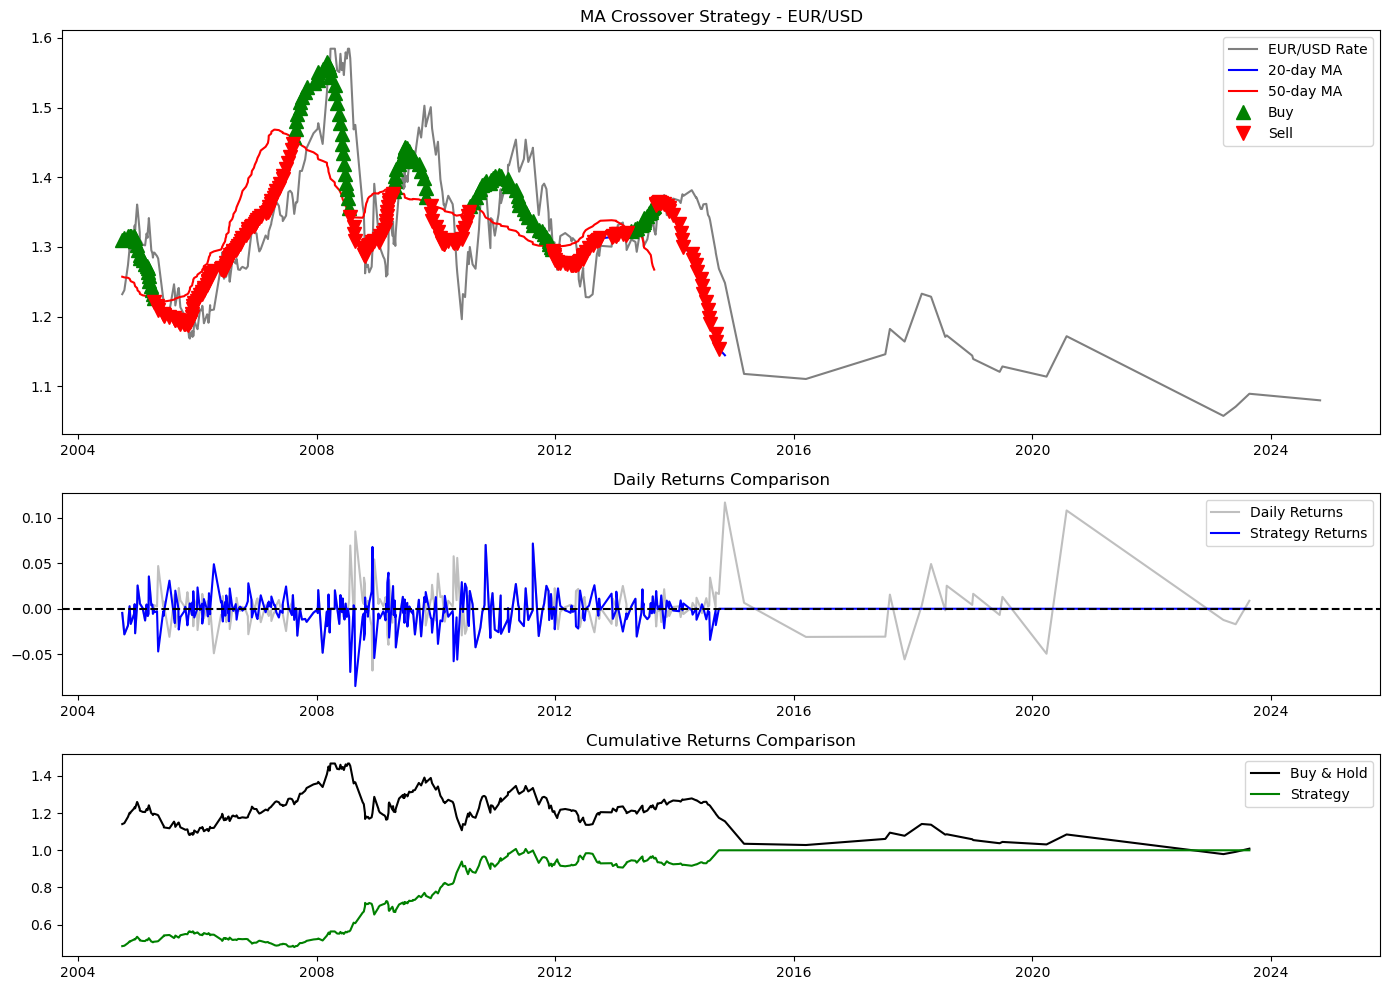

Performance Metrics:
                             Value
Total Market Return         0.1410
Total Strategy Return      -0.5160
Annualized Market Return   -0.0065
Annualized Strategy Return  0.0368
Market Volatility           0.3118
Strategy Volatility         0.2661
Sharpe Ratio (0 risk-free) -1.7276
Max Drawdown               -0.2625
Win Rate                    0.3919


In [10]:
# Parameters
short_window = 20
long_window = 50
currency = 'USD'

# Run strategy
strategy_df = moving_average_crossover_strategy(df, currency, short_window, long_window)

# Visualize
visualize_strategy(strategy_df, currency)

# Show performance
performance = calculate_performance(strategy_df)
print("Performance Metrics:")
print(performance.round(4))

### Interpretation

**This moving average crossover strategy is not effective for this forex pair. It might work better with different parameters, a different asset, or in a trending market rather than a choppy one. You might need to optimize the moving average windows or consider other indicators like RSI or Bollinger Bands to improve the strategy.** 

- The strategy significantly underperforms the market (-51.6% vs. +14.1%).
- High volatility, but not enough reward (negative Sharpe ratio).
- Win rate is low (~39%), meaning most trades are losing.
- Max drawdown is large (-26.25%), indicating high downside risk.
- Despite a positive annualized return (3.68%), the overall strategy failed.

## Conclusion

Our findings indicate that the strategy significantly underperformed the market. While a simple buy-and-hold approach resulted in a 14.1% return, the crossover strategy led to a 51.6% loss. The Sharpe ratio was negative (-1.73), meaning that the risk taken was not justified by the returns. Additionally, the win rate was only 39.19%, meaning most trades resulted in losses.

Despite an annualized return of 3.68%, the strategy experienced a maximum drawdown of -26.25%, highlighting its vulnerability to significant losses. This suggests that the moving average crossover alone is not a reliable trading strategy in this forex market.

### Key Takeaways & Future Improvements

1. Trend Dependence: The strategy may perform better in strongly trending markets but struggled in the given dataset, which likely included sideways or volatile periods.

2. Parameter Optimization: Different short/long moving average windows may improve performance, requiring further tuning.

3. Enhancing with Other Indicators: Combining momentum indicators (e.g., RSI, MACD) or volatility measures (e.g., Bollinger Bands) may refine trade signals.

4. Risk Management: Incorporating stop-loss and take-profit levels can help mitigate large drawdowns.

5. Hedging Potential: While this strategy did not provide effective hedging, exploring options-based or futures-based hedging techniques could enhance risk management in forex trading.